### import required libraries

In [ ]:
!pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
# from keras_tuner import RandomSearch
# from keras_tuner.engine.hyperparameters import HyperParameters

### set konstanta value

In [ ]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCH = 50

### prepare for dataset

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/tomato disease image',
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    shuffle=True
)

Found 5452 files belonging to 4 classes.


In [ ]:
# show class names
class_names = dataset.class_names
class_names

['Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_healthy']

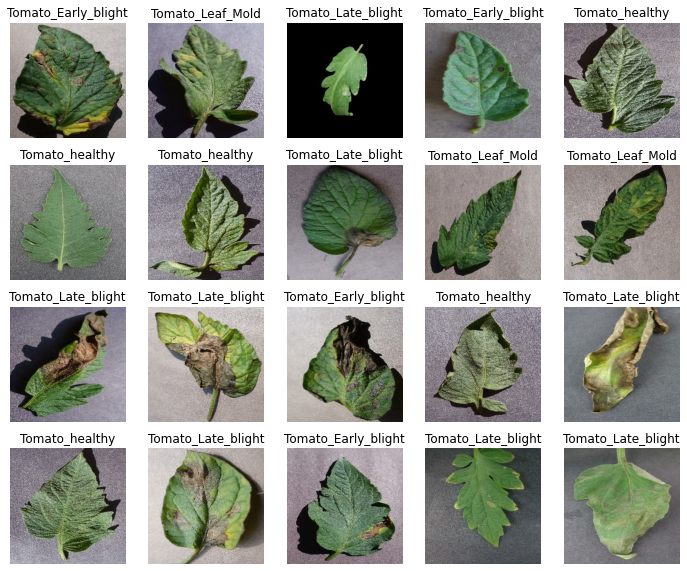

In [ ]:
# visualize 20 sample image
plt.figure(figsize=(12,10))
for image_batch, label_batch in dataset.take(1):
  for i in range(20):
    plt.subplot(4,5,i+1)
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    plt.title(class_names[label_batch[i]])
    plt.axis('off')
plt.show()

### split into train, test, and data validation

In [ ]:
# make function to split
def get_split(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
  ds_size = len(ds)
  if shuffle:
    ds = ds.shuffle(shuffle_size, seed=12)

  train_size = int(train_split * ds_size)
  val_size = int(val_split * ds_size)

  train_ds = ds.take(train_size)
  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size).skip(val_size)

  return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_split(dataset)
len(train_ds), len(val_ds), len(test_ds)

(136, 17, 18)

### cache & prefetch

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

### preprocessing data image

In [ ]:
# resize & rescaling
resize_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [ ]:
# data augmentation
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomContrast(0.1)
])

### Build Model

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4

model = tf.keras.Sequential([
    resize_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes, activation = 'softmax'),
])

model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [ ]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# callback early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=4)

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    epochs=EPOCH,
    verbose=1,
    callbacks=[callback]
)

Epoch 1/50
136/136 [==============================] - 10s 73ms/step - loss: 0.0930 - accuracy: 0.9684 - val_loss: 0.2310 - val_accuracy: 0.9357
Epoch 2/50
136/136 [==============================] - 10s 73ms/step - loss: 0.0850 - accuracy: 0.9695 - val_loss: 0.0778 - val_accuracy: 0.9724
Epoch 3/50
136/136 [==============================] - 10s 73ms/step - loss: 0.1107 - accuracy: 0.9628 - val_loss: 0.3905 - val_accuracy: 0.8585
Epoch 4/50
136/136 [==============================] - 10s 73ms/step - loss: 0.0926 - accuracy: 0.9721 - val_loss: 0.0649 - val_accuracy: 0.9835
Epoch 5/50
136/136 [==============================] - 10s 73ms/step - loss: 0.1147 - accuracy: 0.9619 - val_loss: 0.0922 - val_accuracy: 0.9688
Epoch 6/50
136/136 [==============================] - 10s 73ms/step - loss: 0.0706 - accuracy: 0.9748 - val_loss: 0.0515 - val_accuracy: 0.9779
Epoch 7/50
136/136 [==============================] - 10s 75ms/step - loss: 0.0593 - accuracy: 0.9818 - val_loss: 0.0943 - val_accuracy:

In [ ]:
loss, acc = model.evaluate(test_ds)
loss, acc

18/18 [==============================] - 1s 31ms/step - loss: 0.0261 - accuracy: 0.9948


(0.026114247739315033, 0.9947916865348816)

In [ ]:
len(history.history['loss'])

19

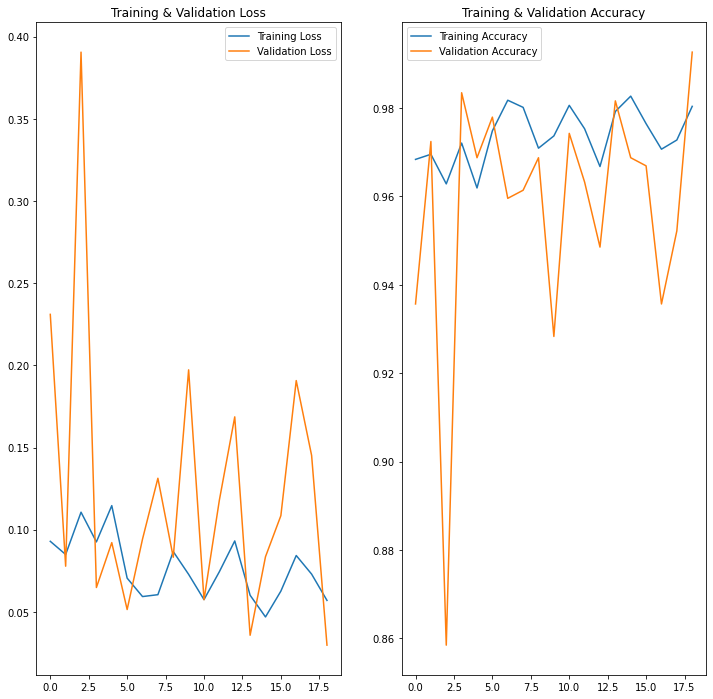

In [ ]:
# visualize loss & acc
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.plot(range(19), loss, label='Training Loss')
plt.plot(range(19), val_loss, label='Validation Loss')
plt.legend()
plt.title('Training & Validation Loss')

plt.subplot(1,2,2)
plt.plot(range(19), acc, label='Training Accuracy')
plt.plot(range(19), val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Training & Validation Accuracy')
plt.show()

### Testing Predict Data

In [ ]:
import numpy as np

Actual: Tomato_Leaf_Mold
Prediction: Tomato_Leaf_Mold


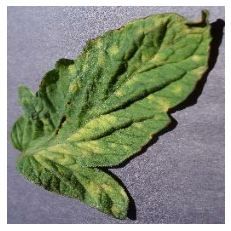

In [ ]:
for images_batch, label_batch in dataset.take(1):
  first_image = images_batch[0].numpy().astype('uint8')
  first_label = label_batch[0].numpy()
  print(f'Actual: {class_names[first_label]}')
  plt.imshow(first_image)
  plt.axis('off')

  image_pred = model.predict(images_batch)
  print(f'Prediction: {class_names[np.argmax(image_pred[0])]}')

In [ ]:
# make function to predict 
def predict(model, img):
  img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array = tf.expand_dims(img_array, 0)

  prediction = model.predict(img_array)
  predicted_class = class_names[np.argmax(prediction[0])]
  confidence = round(100 * (np.max(prediction[0])), 2)
  return predicted_class, confidence

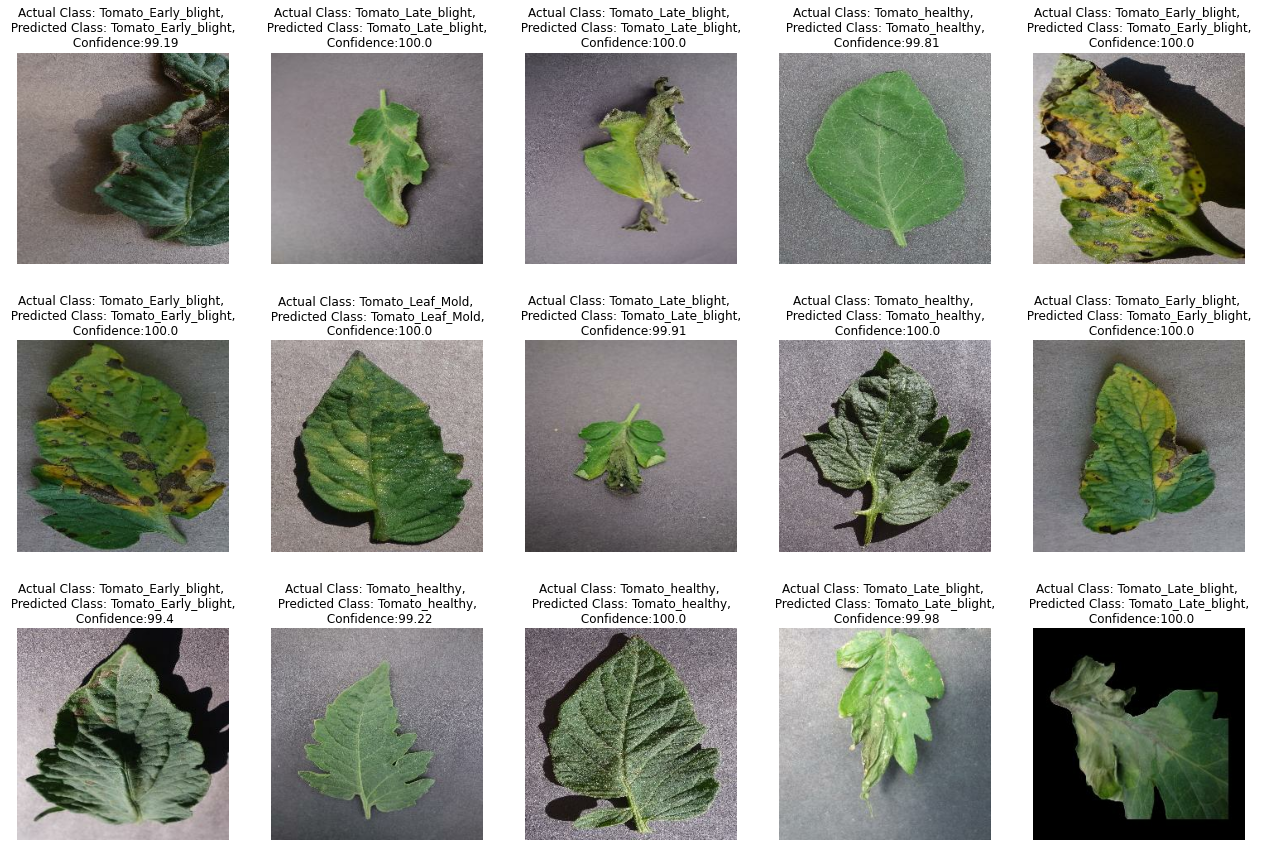

In [ ]:
# visualize new image
plt.figure(figsize=(22,15))
for images, label in dataset.take(1):
  for i in range(15):
    plt.subplot(3,5,i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    predicted_class, confidence = predict(model, images[i].numpy())
    actual_class = class_names[label[i]]
    plt.title(f'Actual Class: {actual_class}, \n Predicted Class: {predicted_class}, \n Confidence:{confidence}')
    plt.axis('off')
plt.show()

### Save Model

In [ ]:
model.save('/content/drive/MyDrive/tomato.h5')

In [ ]:
new_model = tf.keras.models.load_model('/content/drive/MyDrive/tomato.h5')
new_model.evaluate(test_ds)

18/18 [==============================] - 1s 32ms/step - loss: 0.0261 - accuracy: 0.9948


[0.026114247739315033, 0.9947916865348816]

In [ ]:
new_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

### Hyperparameter Tuning using Keras Tuner 
### Compare Performance Between First Model & Model with Hyperparameter Tuning

In [ ]:
# make function to build model
def build_model(hp):  
  model_hp = tf.keras.Sequential([
    layers.Conv2D(
        filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
        activation='relu',
        input_shape=input_shape
    ),
    layers.Conv2D(
        filters=hp.Int('conv_2_filter', min_value=32, max_value=64, step=16),
        kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
        activation='relu'
    ),
    layers.Conv2D(
        filters=hp.Int('conv_3_filter', min_value=32, max_value=64, step=16),
        kernel_size=hp.Choice('conv_3_kernel', values = [3,5]),
        activation='relu'
    ),
    layers.Conv2D(
        filters=hp.Int('conv_4_filter', min_value=32, max_value=64, step=16),
        kernel_size=hp.Choice('conv_4_kernel', values = [3,5]),
        activation='relu'
    ),
    layers.Conv2D(
        filters=hp.Int('conv_5_filter', min_value=32, max_value=64, step=16),
        kernel_size=hp.Choice('conv_5_kernel', values = [3,5]),
        activation='relu'
    ),
    layers.Conv2D(
        filters=hp.Int('conv_6_filter', min_value=32, max_value=64, step=16),
        kernel_size=hp.Choice('conv_6_kernel', values = [3,5]),
        activation='relu'
    ),
    layers.Flatten(),
    layers.Dense(
        units=hp.Int('dense_1_units', min_value=32, max_value=128, step=16),
        activation='relu'
    ),
    layers.Dense(n_classes, activation='softmax')
  ])
  
  model_hp.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
  
  return model_hp

In [ ]:
tuner_search = RandomSearch(build_model,
                            objective='val_accuracy',
                            max_trials=5,
                            directory='output',
                            project_name='Tomato Disease')

ResourceExhaustedError: ignored